Dataset Loaded. Cleaned Training Samples: 8599
Features for Training: 39

=============== Training: Random Forest ===============
Model successfully saved to: models/random_forest.pkl [cite: 64]
                       precision    recall  f1-score   support

        Non-Habitable       1.00      1.00      1.00      1083
Potentially Habitable       0.33      0.17      0.22         6

             accuracy                           0.99      1089
            macro avg       0.66      0.58      0.61      1089
         weighted avg       0.99      0.99      0.99      1089



<Figure size 1000x800 with 0 Axes>

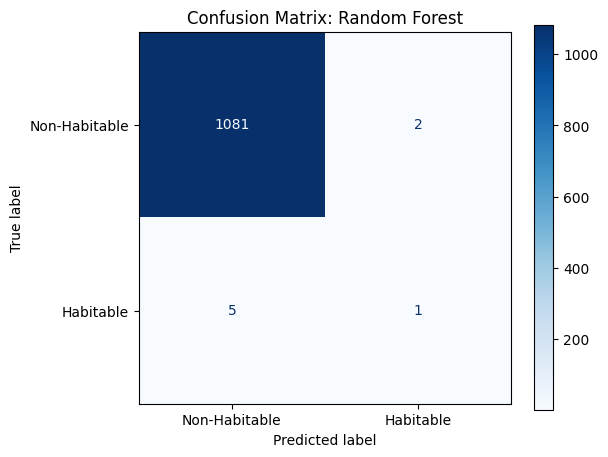


=============== Training: XGBoost ===============


d:\D\Infoysys-internship\ExoHabitAI\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [21:46:36] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Model successfully saved to: models/xgboost.pkl [cite: 64]
                       precision    recall  f1-score   support

        Non-Habitable       1.00      1.00      1.00      1083
Potentially Habitable       0.38      0.50      0.43         6

             accuracy                           0.99      1089
            macro avg       0.69      0.75      0.71      1089
         weighted avg       0.99      0.99      0.99      1089



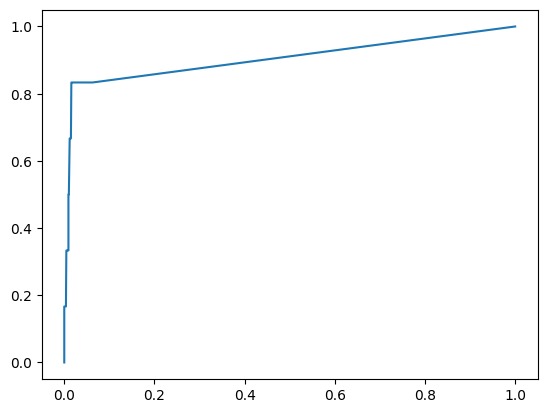

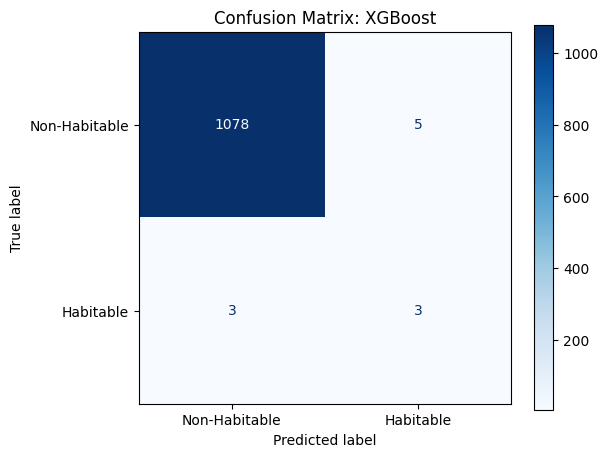

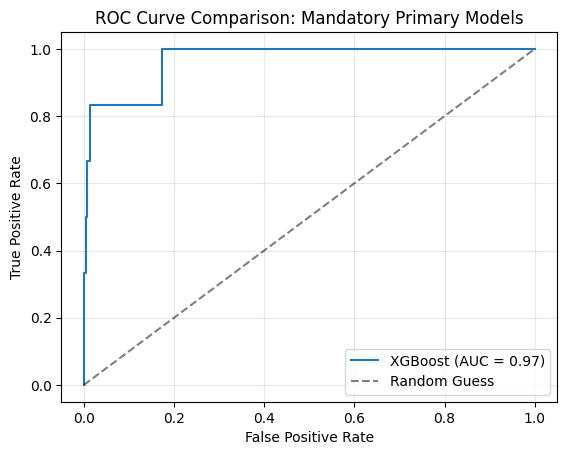


PRIMARY MODEL COMPARISON (MANDATORY)
        Model  Accuracy  Precision   Recall  F1-score  F2-score
      XGBoost  0.992654   0.375000 0.500000  0.428571  0.468750
Random Forest  0.993572   0.333333 0.166667  0.222222  0.185185


In [1]:
import os
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay, 
    roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score,
    fbeta_score # UPGRADE: Added for high-recall optimization
)

# Ensure the storage directory exists for mandatory model saving [cite: 63, 64]
os.makedirs('models', exist_ok=True)

# 1. LOAD PREPARED DATA
# Using the synchronized, cleaned SMOTE-ENN files
X_train = pd.read_csv('X_train_final.csv')
y_train = pd.read_csv('y_train_final.csv').values.ravel()
X_test = pd.read_csv('X_test_final.csv')

# Binarizing the test target (Threshold 0.7 matches Milestone 3 logic) [cite: 10, 11]
y_test_cont = pd.read_csv('y_test_final.csv').values.ravel()
y_test = (y_test_cont > 0.7).astype(int)

print(f"Dataset Loaded. Cleaned Training Samples: {len(X_train)}")
print(f"Features for Training: {X_train.shape[1]}")

# 2. INITIALIZE PRIMARY MODEL PIPELINES [cite: 52, 53]
# Model A: Random Forest Classifier [cite: 39]
rf_pipe = Pipeline([
    ('scaler', StandardScaler()), # Mandatory Scaling [cite: 50, 54]
    ('clf', RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'))
])

# Model B: XGBoost Classifier [cite: 43]
# Note: scale_pos_weight is used to handle any remaining minor class imbalance
xgb_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', XGBClassifier(
        n_estimators=100, 
        learning_rate=0.1, 
        random_state=42, 
        use_label_encoder=False, 
        eval_metric='logloss',
        scale_pos_weight=2 # Giving habitable class slightly more weight [cite: 44, 45]
    ))
])

# 3. TRAINING, STORAGE, & EVALUATION LOOP
primary_models = {
    "Random Forest": rf_pipe,
    "XGBoost": xgb_pipe
}

model_performance = []
plt.figure(figsize=(10, 8)) # Setup for Mandatory ROC Curve [cite: 73]

for name, pipe in primary_models.items():
    print(f"\n{'='*15} Training: {name} {'='*15}")
    
    # 3.1. Fit models on training data [cite: 60]
    pipe.fit(X_train, y_train)
    
    # 3.2. Save trained models using joblib [cite: 62]
    model_filename = f'models/{name.lower().replace(" ", "_")}.pkl'
    joblib.dump(pipe, model_filename)
    print(f"Model successfully saved to: {model_filename} [cite: 64]")
    
    # 3.3. Predictions & Probabilities
    y_pred = pipe.predict(X_test)
    y_probs = pipe.predict_proba(X_test)[:, 1] # Probability for Ranking [cite: 96]
    
    # 3.4. Calculate Metrics including F2-Score 
    metrics = {
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, zero_division=0),
        "Recall": recall_score(y_test, y_pred),
        "F1-score": f1_score(y_test, y_pred, zero_division=0),
        "F2-score": fbeta_score(y_test, y_pred, beta=2, zero_division=0) # Recall Priority
    }
    model_performance.append(metrics)
    
    # 3.5. Mandatory Output: Classification Report [cite: 72]
    print(classification_report(y_test, y_pred, target_names=['Non-Habitable', 'Potentially Habitable']))
    
    # 3.6. Mandatory Output: Confusion Matrix [cite: 71]
    fig, ax = plt.subplots(figsize=(6, 5))
    ConfusionMatrixDisplay.from_predictions(
        y_test, 
        y_pred, 
        display_labels=['Non-Habitable', 'Habitable'], 
        cmap='Blues', 
        ax=ax
    )
    plt.title(f"Confusion Matrix: {name}")
    plt.grid(False)
    plt.show()
    
    # 3.7. Generate ROC Curve Data [cite: 73]
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

# 4. FINALIZE ROC CURVE COMPARISON [cite: 73]
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison: Mandatory Primary Models')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

# 5. MODEL COMPARISON SUMMARY [cite: 87, 88]
comparison_df = pd.DataFrame(model_performance)
print("\n" + "="*50)
print("PRIMARY MODEL COMPARISON (MANDATORY)")
print("="*50)
print(comparison_df.sort_values(by='F2-score', ascending=False).to_string(index=False))